# Big Data Final Exam - Quentin Le Roux

  * You can use Colab or your local installation
  * Rename the notebook with your Surname
  * SEND THE .ipynb file to `marco.milanesio@univ-cotedazur.fr` 
  * **DEADLINE** 12-01-2021 at 23h59.

## Usual preamble to a `Spark` notebook on google.colab...

Let's load the data.


In [1]:
!ls

big-data-exam_Q-Le-Roux.ipynb  boston.csv
big-data-exam_Q-Le-Roux.zip    test.pdf


You should have now `boston.csv` in your folder.

## ... or continue from here if you run locally on your machine

## Housing prices in Boston

The goal is to predict the housing prices in the Boston area.

The data is as follows:
  * `crim` — per capita crime rate by town.
  * `zn` — proportion of residential land zoned for lots over 25,000 sq.ft.
  * `indus` — proportion of non-retail business acres per town.
  * `chas` — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
  * `nox` — nitrogen oxides concentration (parts per 10 million).
  * `rm` — average number of rooms per dwelling.
  * `age` — proportion of owner-occupied units built prior to 1940.
  * `dis` — weighted mean of distances to five Boston employment centres.
  * `rad` — index of accessibility to radial highways.
  * `tax` — full-value property-tax rate per $10,000.
  * `ptratio` — pupil-teacher ratio by town.
  * `black` — 1000(Bk — 0.63)<sup>2</sup> where Bk is the proportion of blacks by town.
  * `lstat` — lower status of the population (percent).
  * `medv` — median value of owner-occupied homes in \$1000s. **This is the target variable.**

In [2]:
# Imports libraries used in this notebook

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import LinearRegression

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns

## 0 - Create a spark session named 'houses'

In [3]:
# Instantiates the spark session locally
# If it does not work, try changing the config memory value

spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "2g") \
    .appName("houses") \
    .getOrCreate()

In [4]:
# Checks the spark session running in memory

spark

## 1 - Load the `boston.csv` file into the session
Use proper values for `inferSchema` and `header`, depending on the file itself...

**CALL IT `bostondf`** Otherwise some code may not work later

In [5]:
# Loads the bostondf dataset

bostondf = (spark
            .read
            .format("csv")
            .options(header=True, inferSchema=True)
            .load("boston.csv"))

## 2 - Print the dataframe schema

In [6]:
# Prints the dataset's schema

bostondf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



## 3 - Show the first 3 rows of the dataframe

In [7]:
# Shows the first 3 rows of the dataset

bostondf.show(3)

+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|_c0|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio| black|lstat|medv|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|  1|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|  2|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|  3|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 3 rows



## 4 - Output basic stats on the dataset.

*hint*: for readability purposes you can `transpose` a description dataframe.


In [8]:
# Drops the column _c0 (index/ID numbering each entry).
# It has no consequence on the modeling of medv.

bostondf.drop("_c0").toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


## 5 - Scatter Matrix (use pandas)

Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables. `pandas` does it for us.


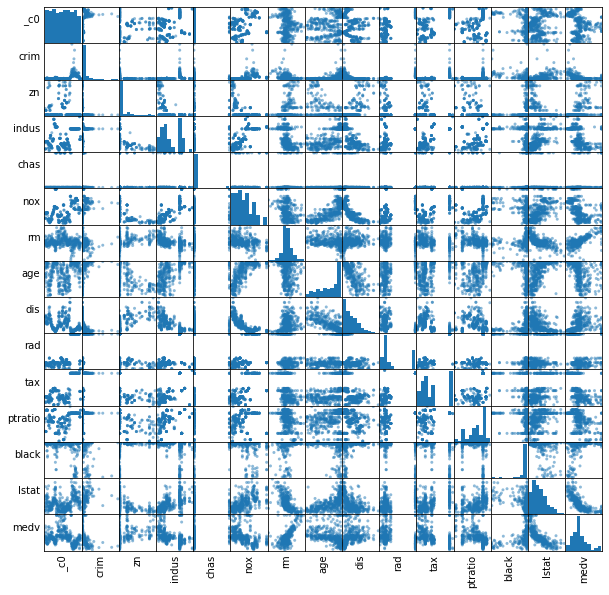

In [9]:
# DON"T CHANGE THIS. JUST RUN IT
import pandas as pd

numeric_features = [t[0] for t in bostondf.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = bostondf.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## 6 - Comment on the scatterplot

Scatterplot matrices are **good for determining rough linear correlations of data that contain continuous variables**. Scatterplot matrices are not so good for looking at discrete variables.

- The ``crim`` (per capita crime rate by town) variable seems to have a weak positive relationship with the variables: ``nox`` (nitrogen oxides concentration), ``age`` (proportion of owner-occupied units built prior to 1940), and ``lstat`` (lower status of the population). This may indicate that a higher crime incidence happens in neighborhoods where buildings are older and where a high concentration of nitrogen oxides are measured. The corollary is that ``crim`` seems to have a negative relationship with the ``medv`` variable (median value of owner-occupied homes), incidentally our target variable.

- As a reminder, zoning laws regulate the use of land within a municipality. It controls the ways in which the land can be developed and what purposes the zoned land can serve. The ``zn`` (proportion of residential land zoned for lots over 25,000 sq.ft.) variable has a strong negative relationship with the ``indus`` (proportion of non-retail business acres per town) variable (logical as one excludes the other) and with the ``nox`` variable, indicating that residential zoning areas are selected away from places with a high concentration of nitrogen oxide. Similarly, the variable has a negative relationship with ``age`` and ``lsat``, indicating that the proportion of residential land zoned for lots over a certain size may target higher income earning areas and areas with a recent building history. The variable has a positive relationship with ``dis`` and ``medv`` (our target variable), indicating that zoning may happen in suburban areas rather than the city centers of Boston, which are historically poorer than the peripheries in the USA.


- ``indus`` has a strong positive relationship with ``nox``, expectedly as industries are more likely to reject those polluting particles. It seems to have a negative relationship with ``medv``(our target variable), understandably as proximity to industries generally lowers house prices. 

- The variable ``chas`` (a dummy variable that is either 0 or 1) seems to be weakly correlated with the rest of the variables, which is expected to see as scatter plot matrices are not very efficient for looking at discrete variables.

- ``nox`` seems to have a positive relationship with ``age``, indicating that areas where old buildings exist have a higher incidence of air pollution. Meanwhile the variable has a negative relationship with ``dis`` and ``medv`` (our target variable).


- ``rm`` (average number of rooms per dwelling) does not seem to have a strong relationship with most features except a weak positive relationship with ``zn`` and a negative relationship with ``lsat``, and incidentally a positive relationship with the ``medv`` target value. It indicates that house prices tend to rise with the room number while areas while a lower-income population have smaller houses.


- As mentioned prior, ``age`` has a negative relationship with ``zn``, ``dis``, and ``medv``, indicating that the overall age of buildings in an area negatively impacts the median value there. 


- ``dis`` seem to have a positive relationship with ``zn`` as mentioned prior, while showing a negative relationship with ``indus``, ``nox``, and ``age``. Meanwhile it has a weak positive relationship with our target variable ``medv``.


- Using the scatter matrix, it is hard to read ``rad`` (index of accessibility to radial highways) and ``ptratio`` (pupil-teacher ratio by town) as they are strongly clustered variable with regards to their impact on our target variable ``medv``. However they seem to have a negative impact trend.


- ``tax`` (full-value property-tax rate) does not seem to have strong relations with other features except maybe a negative relationship with ``medv`` (our target variable), indicating that the relative real estate tax rate on a house value decreases with it, penalizing smaller, cheaper houses.


- ``lsat`` has a positive relationship with ``crim``, ``indus``, ``nox``, and ``age`` while showing a negative relationship with ``rm``, ``dis``, and incidentally our target variable ``medv``. It indicates that lower-income neighborhoods are closer to old city centers, polluting industries, and areas of employment (highlighting the US suburban city planning trend), which impacts the median value of houses.


To summarize, the target variable ``medv`` seems to show the following relationships with the available features:

| features | relationship with ``medv`` |
| ---      | ---          | 
| crim     | negative |
| zn       | positive |
| indus    | negative |
| chas     | weak positive |
| nox      | negative |
| rm       | strong positive |
| age      | negative |
| dis      | weak positive |
| rad      | *likely* negative |
| tax      | *likely* negative |
| ptratio  | *likely* negative |
| black    | (see note) |
| lstat    | strong negative |

**Note:** The inclusion of race as part of a dataset raises concerns with regards to ethics. As such we need to consider pruning that column from it (source: [AI has exacerbated racial bias in housing. Could it help eliminate it instead?](https://www.technologyreview.com/2020/10/20/1009452/ai-has-exacerbated-racial-bias-in-housing-could-it-help-eliminate-it-instead/) by the MIT Technology Review).  


## 7 - Compute all correlations with the target variable (`medv`)

*hint*: look at the `stat` attribute of the dataframe

In [10]:
# Prints the correlation of each feature column with the target variable medv
    
correlations = {column:round(bostondf.stat.corr("medv", column),4) 
                for column in bostondf.columns[1:-1]}

print("Feature's correlation metric with the target variable 'medv':")
correlations

Feature's correlation metric with the target variable 'medv':


{'crim': -0.3883,
 'zn': 0.3604,
 'indus': -0.4837,
 'chas': 0.1753,
 'nox': -0.4273,
 'rm': 0.6954,
 'age': -0.377,
 'dis': 0.2499,
 'rad': -0.3816,
 'tax': -0.4685,
 'ptratio': -0.5078,
 'black': 0.3335,
 'lstat': -0.7377}

## 8 - Data preparation

We keep all the variables, for now. **WHY?**

To prepare the data we need features and labels.
Being that data is numerical, we do not have to perform any encoding. Just build the `Vector`.

In [11]:
# Removes the _c0 and mdev columns; goal: keeping only the features columns
input_columns = bostondf.columns[1:-1] 

# Builds a PySpark data processing pipeline via the VectorAssembler and Pipeline objects
features = VectorAssembler(inputCols=input_columns, outputCol='features')
pipeline = Pipeline(stages=[features])

# Displays the processed dataset
v_df = pipeline.fit(bostondf).transform(bostondf).select(["features", "medv"])
v_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



Let's split the dataset into training and testing sets with a 70:30 ratio

In [12]:
# DONT CHANGE THIS, Just RUN IT.
splits = v_df.randomSplit([0.7, 0.3], seed = 1)
train_df = splits[0]
test_df = splits[1]

## 9 - Linear regression

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.regression).

Build a linear regression model to fit the data.
  * feature column: `features`
  * label column: `medv`
  * maxIter: 10
  * regParam: 0.3
  * elasticNetParam: 0.8  <- optional

Fit the model and print `coefficients` and `intercept`

In [13]:
# Declares the model
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, 
                      featuresCol = 'features', labelCol = 'medv')

# Fits the model
lr_model = lr.fit(train_df)

# Prints the coefficients and intercept
print(f"Coefficients:\n {lr_model.coefficients}\n")
print(f"Intercept:\n {lr_model.intercept}")

Coefficients:
 [0.0,0.016422733199110046,0.0,2.7264086022377976,-7.7588664171227855,4.622698614602201,-0.005354680919086761,-0.7058734696399848,0.0,-0.0006796931720564879,-0.7015193437775934,0.011043171064681417,-0.46259222598577454]

Intercept:
 15.470088646365294


## 10 - Summary and RMSE

Print the summary of the model, the `RMSE` and the `r2` errors

In [14]:
# Creates a summary model from the trained model
training_summary = lr_model.summary

In [15]:
# Prints some elements of the summary among available methods:
# See:
# https://spark.apache.org/docs/latest/api/python/pyspark.ml.html?highlight=summary#pyspark.ml.regression.LinearRegressionModel.summary

print(f"Number of iterations:\n {training_summary.totalIterations}\n" + 
      "(Recall the model starts with iteration 0, 'maxIter=10' implies " +
      "that there can be 11 iterations maximum)\n") 

print("Objective history of model (Objective function (scaled loss " + 
      "+ regularization) at each iteration):\n" +
      f"{training_summary.objectiveHistory}.")

Number of iterations:
 11
(Recall the model starts with iteration 0, 'maxIter=10' implies that there can be 11 iterations maximum)

Objective history of model (Objective function (scaled loss + regularization) at each iteration):
[0.49999999999999956, 0.4318594648288011, 0.24100259003989624, 0.22012327979142265, 0.1891638056242696, 0.1853271342870122, 0.1840011367420315, 0.18266390794813286, 0.18199524465744962, 0.1816320963826407, 0.1816032806964706].


In [16]:
# Prints  the residuals summary, and the RMSE and r2 errors

# training_summary.residuals.show(10)
print(f"RMSE: {training_summary.rootMeanSquaredError}")
print(f"r2: {training_summary.r2}")

RMSE: 4.609091956958162
r2: 0.7184339289249144


RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual `medv` value, such as mean, min and max.

In [17]:
# Creates a modeled values vs actual values dataframe for showing
# comparison statistics and plots

# Note: We keep working with the train_df as the next section (11) is about
# predicting on the test_df

modeled_vs_actuals = lr_model.transform(train_df).drop("features").toPandas()
modeled_vs_actuals.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
medv,354.0,22.284746,8.698402,5.600000,16.725000,21.150000,25.000000,50.000000
prediction,354.0,22.284746,7.011928,0.272888,18.052147,21.891193,26.768405,42.356244


<AxesSubplot:title={'center':'Comparison of medv and prediction distributions'}, ylabel='Frequency'>

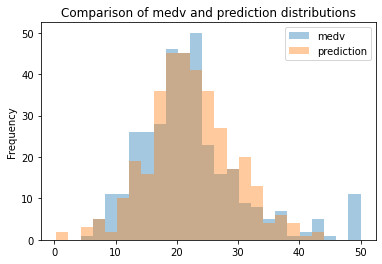

In [18]:
# Plots the medv and pred value distributions using the pandas library

modeled_vs_actuals.plot.hist(alpha=0.4, 
                             bins=25,
                             title="Comparison of medv and prediction distributions")

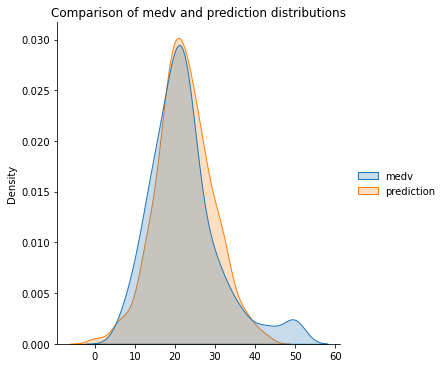

In [19]:
# Plots the medv and pred value distributions using the Seaborn library

sns.displot(modeled_vs_actuals, 
            kind="kde",
            fill=True).set(title="Comparison of medv and prediction distributions")

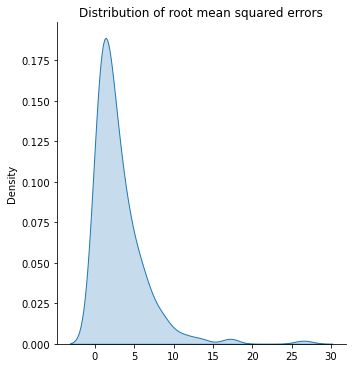

In [20]:
# Plots the RMSE distributions using the Seaborn library

rmse = np.sqrt((modeled_vs_actuals["medv"] - modeled_vs_actuals["prediction"])**2)
sns.displot(rmse, kind="kde", fill=True).set(title="Distribution of root mean squared errors")

In [21]:
# Performs a Kolmogorov-Smirnov test using the scikit-learn library between the
# distribution of the medv and prediction values

ks_2samp(modeled_vs_actuals["medv"], modeled_vs_actuals["prediction"])

KstestResult(statistic=0.0847457627118644, pvalue=0.1573712742840959)

What can you infer from this results? Is it good or is it bad?


## 11 - Predictions

Make preditions and evaluate the model (e.g., with `RMSE`). We will use a `RegressionEvaluator` for this.

In [22]:
# Predicts the medv values on the test dataset

lr_predictions = lr_model.transform(train_df)
lr_predictions.select("prediction","medv","features").show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 29.89441358723169|24.0|[0.00632,18.0,2.3...|
|31.141522274748663|32.2|[0.00906,90.0,2.9...|
|27.471243121438455|22.0|[0.01096,55.0,2.2...|
|31.609540695003883|32.7|[0.01301,35.0,1.5...|
|38.459461877315206|50.0|[0.01381,80.0,0.4...|
+------------------+----+--------------------+
only showing top 5 rows



In [23]:
# DON'T TOUCH THIS. JUST RUN
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.718434


In [24]:
# Evaluates the RMSE metric of the model on the test dataset predictions

test_result = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="rmse")
print(f"Root Mean Squared Error (RMSE) on test data = {test_result.evaluate(lr_predictions)}")

Root Mean Squared Error (RMSE) on test data = 4.609091956958162


In [25]:
# Prints the number of iterations and objective history of the model
# Prints the residuals

print(f"numIterations: {lr_model.summary.totalIterations}")
print(f"objectiveHistory: {lr_model.summary.objectiveHistory}")

lr_model.summary.residuals.show()

numIterations: 11
objectiveHistory: [0.49999999999999956, 0.4318594648288011, 0.24100259003989624, 0.22012327979142265, 0.1891638056242696, 0.1853271342870122, 0.1840011367420315, 0.18266390794813286, 0.18199524465744962, 0.1816320963826407, 0.1816032806964706]
+--------------------+
|           residuals|
+--------------------+
|  -5.894413587231689|
|  1.0584777252513398|
|  -5.471243121438455|
|    1.09045930499612|
|  11.540538122684794|
|  0.5166593357331273|
| -1.2915183595492792|
| -2.9617103947352383|
|    7.86722126692937|
|     8.7991240529673|
|  3.8735018652620603|
| -1.1799746372275237|
|   5.647404540431992|
|-0.12862866294867104|
|  -9.304116032972424|
| -3.7868917194930525|
|  3.6657331208161565|
|   -3.48831124871397|
|  1.5000043862639352|
| -1.8518534742609205|
+--------------------+
only showing top 20 rows



We can use the model to make some predictions on the testing set.

In [26]:
# Prints the predictions made on the test dataset

predictions = lr_model.transform(test_df)
predictions.select("prediction", "medv", "features").show()

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 30.51173419938103|35.4|[0.01311,90.0,1.2...|
|17.733278400164508|18.9|[0.0136,75.0,4.0,...|
|31.395907407183575|32.9|[0.01778,95.0,1.4...|
|26.081621467847707|23.1|[0.0187,85.0,4.15...|
|25.963544832353087|33.0|[0.01951,17.5,1.3...|
| 20.87123015395185|20.1|[0.01965,80.0,1.7...|
|39.673129139294765|50.0|[0.02009,95.0,2.6...|
|19.594500706610003|18.5|[0.03041,0.0,5.19...|
| 30.73703788611705|34.9|[0.0315,95.0,1.47...|
|29.470424038583083|33.4|[0.03237,0.0,2.18...|
|   32.397616782011|34.9|[0.03359,75.0,2.9...|
|  30.7571162752487|28.5|[0.03502,80.0,4.9...|
| 22.66081083233045|20.9|[0.03548,80.0,3.6...|
| 24.34126320692633|22.9|[0.03551,25.0,4.8...|
|36.790735311098004|45.4|[0.03578,20.0,3.3...|
|25.795412969544813|23.2|[0.03871,52.5,5.3...|
|35.426001793789055|33.3|[0.04011,80.0,1.5...|
| 26.11166237306857|24.8|[0.04297,52.5,5.3...|
|23.701704497

## 12 - Decision tree regression and Gradient-boosted tree regression

Try to do the same thing with these 2 regressors.
Which will result better? 

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor).

In [27]:
# Trains and evaluates Decision Tree Regressors on the train than test datasets
# on a max-depth range of 1 to 19 and output the best result.
# The best max-depth will be used in the gradient-boosted tree regression for 
# comparison purposes.

rmses = []
depths = []

for depth in list(range(1, 20)): #could use getGridParams
    
    dt = DecisionTreeRegressor(maxDepth=depth, 
                               featuresCol="features", 
                               labelCol="medv")
    dt_model = dt.fit(train_df)
    dt_predictions = dt_model.transform(test_df)
    dt_evaluator = RegressionEvaluator(labelCol="medv", 
                                       predictionCol="prediction", 
                                       metricName="rmse")
    
    rmses.append(dt_evaluator.evaluate(dt_predictions))
    depths.append(dt_model.getMaxDepth())

rmse = min(rmses)
depth = depths[rmses.index(rmse)]
print(f"minimum Root Mean Squared Error (RMSE) on test data, {round(rmse,4)}, " +
      f"was achieved at max_depth {depth}.")

minimum Root Mean Squared Error (RMSE) on test data, 4.4237, was achieved at max_depth 6.


### Gradient-boosted tree regression

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.GBTRegressor).

In [28]:
# Trains and evaluates a gradient-boosted tree Regressor on the train than test 
# datasets using the same max-depth parameter as the best model obtained with 
# a Decision Tree Regressor

gbt = GBTRegressor(maxDepth=6, maxIter = 10,
                   labelCol="medv")
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

gbt_predictions.select('prediction', 'medv', 'features').show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 32.92471959506846|35.4|[0.01311,90.0,1.2...|
|16.285833193025272|18.9|[0.0136,75.0,4.0,...|
| 29.32768331202358|32.9|[0.01778,95.0,1.4...|
|  23.6773227622785|23.1|[0.0187,85.0,4.15...|
|34.917765653003194|33.0|[0.01951,17.5,1.3...|
+------------------+----+--------------------+
only showing top 5 rows



In [29]:
# Evaluates the gradient-boosted tree regressor

gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.38216


| RMSE Regression | RMSE Decision Tree | RMSE Gradient-Boosted Tree | 
| --- | --- | --- | 
| 4.60909 | 4.4237 | 4.38216| 

<u>Conclusion</u>

**In such a situation, it seems that of the three models we have implemented, the Gradient Boosted Tree Regressor is the one with the least error (achieved at a max_depth of 6).**